In [1]:
import pandas as pd
import numpy as np
import cvxpy as cp
from price import *
from kalman import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import dates

(CVXPY) Apr 28 12:25:12 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Apr 28 12:25:12 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


In [2]:
# Import data
df = pd.read_csv('data/stock_price.csv', index_col = 0, header=[0,1])
sp500 = pd.read_csv('data/sp500.csv')

In [3]:
close_price = df[['Adj Close']]
close_price.columns = close_price.columns.droplevel(0)
volume = df[['Volume']]
volume.columns = volume.columns.droplevel(0)
# close_price

In [4]:
actual_R_mat = close_price.pct_change()
actual_R_mat = actual_R_mat[1:]

return_matrix = close_price.pct_change().shift(0)

In [5]:
train_period = 0.2

In [6]:
# Prediction using Kalman Filter
res1 = pd.DataFrame()
res2 = pd.DataFrame()
for fid in tqdm(close_price.columns):
#     print(fid)
    temp_close = close_price[fid]
    temp_volume = volume[fid]
    data = pd.DataFrame({'target':temp_close.shift(-1)/temp_close-1,'return':temp_close/temp_close.shift()-1,'return_vol':temp_volume/temp_volume.shift()-1})
    data.index = temp_close.index.values
    a = pd.DataFrame({fid:calc_kalman(data,train_period)})
    res1 = pd.concat([res1, a], axis = 1)
    a = pd.DataFrame({fid:calc_kalman_multi(data,train_period)})
    res2 = pd.concat([res2, a], axis = 1)

AAPL
ABBV
ABT
AMZN
BA
BAC
C
CSCO
CVX
DIS
GOOGL
HD
IBM
JNJ
JPM
KO
MA
MCD
META
MRK
MSFT
NKE
NVDA
PFE
PG
T
UNH
V
VZ
WMT


## Optimization Model

In [56]:
def NPM(r, his_r, x_tilde, theta, c):
    '''
    param r [ndarray]: vector of predicted return at period t
    param his_r [ndarray]: 2d vector of return for the past W periods; his_r[i][j] = price 
    param x_tilde [ndarray]: investment weights at the end of period t-1
    param theta [float]: acceptable risk level in the range of (0, 1), smaller theta could lead to infeasible solution
    param c [float]: transacion cost in the range of (0, 1)

    '''
    M = len(r) # Number of assets in the portfolio
    W = len(his_r) # Number of recents prices used to measure risk
    
    # Define variables
    u = cp.Variable(M)
    v = cp.Variable(M)
    d = cp.Variable(W)
    g = cp.Variable(W)
    
    # Define Objective
    objective = cp.Maximize(r @ x_tilde + (x_tilde - c/2) @ u - (x_tilde + c/2) @ v)
    
    # Define constraints
    constraints = [cp.sum(u - v) == 0,
                    -(u - v + x_tilde) <= 0,
                    u - v + x_tilde <= 1,
                    u >= 0, v >= 0, d >= 0, g >= 0]
    
    constraints += [cp.sum(d + g) <= W * theta]
    for j in range(W):
#         print('day', -1-j, np.sum(r - his_r[-1-j]))
        constraints += [(his_r[-1-j] - r) @ u - (his_r[-1-j] - r) @ v - d[j] <= (r - his_r[-1-j]) @ x_tilde,
                        (r - his_r[-1-j]) @ u - (r - his_r[-1-j]) @ v - g[j] <= (his_r[-1-j] - r) @ x_tilde]
        
    # Solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve(verbose = False, solver='ECOS_BB')
    if problem.status != cp.OPTIMAL:
        print('problem status', problem.status)
#     constraints_value = [constraint.value for constraint in constraints]
#     print(constraints_value)
        
    return problem, u.value, v.value, d.value, g.value

Algorithm

In [86]:
weight_mat = []
assets = close_price.columns
# assets =  assets[assets != 'NVDA']

pred_R_mat = res2
actual_R_mat = actual_R_mat 
N = len(pred_R_mat)
num_his = 6 # Number of historical days
init_weight = np.ones(len(assets)) / len(assets) # Start with uniform weight
theta = 0.05 # Risk level
c = 0.001 # Transaction Cost
start_day = pred_R_mat.iloc[:, 1].first_valid_index()
# print(start_day)
start_day = pred_R_mat.index.get_loc(start_day)

w = init_weight
# weight_mat.append(w)
for t in tqdm(range(start_day,N)):
    # In the paper, return is defined as pt/pt-1, so we should +1
    predicted_return = np.array((pred_R_mat+1).iloc[t][assets])
    historial_w_actual_returns = (actual_R_mat+1).iloc[t - num_his : t, :][assets]
    historial_w_actual_returns = historial_w_actual_returns.values
#     print('day', t)
    problem, u, v, d, g = NPM(predicted_return, historial_w_actual_returns, w, theta, c)
    w = w + u - v
    weight_mat.append(w)

100%|██████████████████████████████████████████████████████████████████████████████| 2011/2011 [00:50<00:00, 39.73it/s]


Analyze the strategy

In [87]:
signal = pd.DataFrame(np.array(weight_mat), columns = assets, index = close_price.index[start_day : N])
signal

,AAPL,ABBV,ABT,AMZN,BA,BAC,C,CSCO,CVX,DIS,...,MSFT,NKE,NVDA,PFE,PG,T,UNH,V,VZ,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2015-03-24,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,...,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,0.033333,3.333333e-02
2015-03-25,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,...,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,0.033333,3.333333e-02
2015-03-26,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,...,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,0.033333,3.333333e-02
2015-03-27,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,...,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,0.033333,3.333333e-02
2015-03-30,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,...,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,3.333333e-02,0.033333,3.333333e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-13,6.884502e-14,1.081031e-13,6.933545e-14,1.021051e-13,1.046589e-13,5.028033e-14,-7.890730e-14,3.763129e-14,5.990337e-14,7.676332e-14,...,9.763648e-14,6.735636e-14,1.132178e-13,3.392563e-14,6.371131e-14,7.013940e-14,6.517528e-14,5.243473e-14,1.000000,5.112850e-14
2023-03-14,5.312490e-14,6.185843e-14,5.617391e-14,7.629276e-14,2.626681e-14,1.092909e-13,1.046045e-13,3.860887e-14,3.630518e-14,6.425019e-14,...,6.282681e-14,5.223270e-14,9.517744e-14,5.702855e-14,5.359950e-14,4.026331e-14,4.117076e-14,5.462223e-14,1.000000,4.410263e-14
2023-03-15,6.266666e-14,6.778240e-14,4.816447e-14,1.056208e-13,5.783980e-14,1.334012e-13,4.205472e-14,6.272254e-14,-2.465064e-14,7.820628e-14,...,9.540464e-14,6.272413e-14,1.176374e-13,5.665202e-14,5.356028e-14,5.038045e-14,5.417043e-14,1.867074e-14,1.000000,5.445880e-14


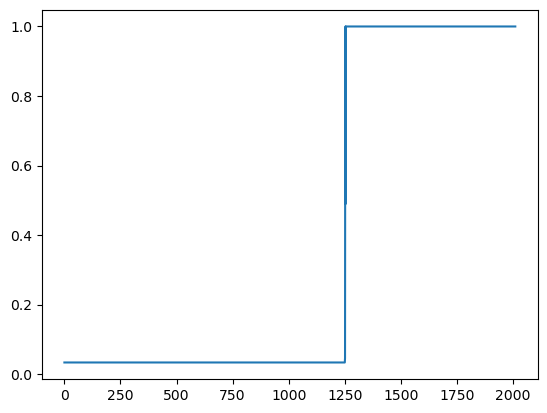

In [98]:
plt.plot(signal.max(axis = 1).values)

In [89]:
# Benchmark - buy-and-hold
benchmark = actual_R_mat.copy()
benchmark['yield'] = benchmark.apply(lambda x: x.mean(), axis = 1)
benchmark['netvalue'] = benchmark['yield'].cumsum() + 1
benchmark.reset_index(inplace = True)
benchmark['Date'] = pd.to_datetime(benchmark['Date'])

In [90]:
result = signal*return_matrix
result['yield'] = result.apply(lambda x: x.sum(), axis = 1)
result['netvalue'] = result['yield'].cumsum() + 1
# result['netvalue'] = (result['yield']+1).cumprod()
result['draw'] = np.maximum.accumulate(result['netvalue']) - result['netvalue']
result.reset_index(inplace = True)

In [91]:
result['Date'] = pd.to_datetime(result['Date'])
result['draw'] = (result['netvalue']-np.maximum.accumulate(result['netvalue']))
index_j = np.argmax(np.maximum.accumulate(result['netvalue']) - result['netvalue'])  # 结束位置
index_i = np.argmax(result['netvalue'][:index_j])  # 开始位置
index_dif = (result.Date[index_j] -  result.Date[index_i]).days
b = pd.to_datetime(result.Date.values[0])
e = pd.to_datetime(result.Date.values[-1])
years = (e-b).days/252
turnover = np.mean(signal.diff().abs().mean())
anyield = (result['netvalue'].iloc[-1]-1-len(signal)*turnover*0.0008)/years
maxdraw = np.min(result['draw'])
sharpe = round(result['yield'].mean()/result['yield'].std()*(np.sqrt(252)),4)
calmar = anyield/(-1*maxdraw)
print(maxdraw)
print('sharpe', sharpe)
print('calmar', calmar)

-0.4633960584743666
sharpe 0.3515
calmar 0.08161937780112176


In [92]:
turnover

8.145405624569188e-05

In [93]:
# return_matrix
target = (return_matrix['AAPL'] + return_matrix['NVDA'])/2
a = target.cumsum() + 1 

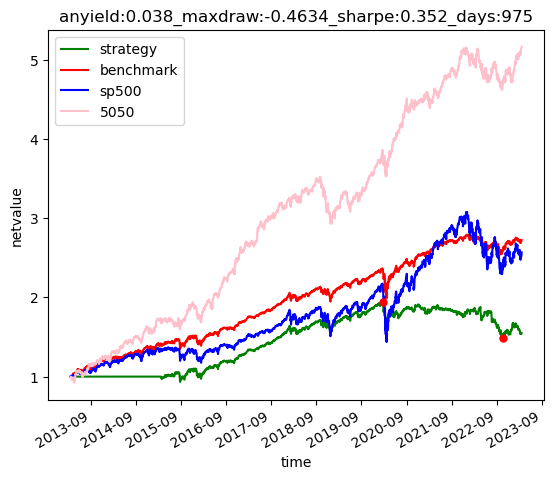

In [94]:
sp500['Date'] = pd.to_datetime(sp500['Date'])

fig = plt.figure()
axis = fig.add_subplot(1, 1, 1)
axis.plot(result.Date,result.netvalue, color = 'green', label = 'strategy')
axis.plot(benchmark.Date,benchmark.netvalue, color = 'red', label = 'benchmark')
axis.plot(sp500.Date,sp500.Close/sp500.Close.iloc[0], color = 'blue', label = 'sp500')
axis.plot(result.Date,a, color = 'pink', label = '5050')

axis.plot([result.Date[index_i], result.Date[index_j]], [result['netvalue'][index_i], result['netvalue'][index_j]], 'o', color="r", markersize=5)
axis.xaxis.set_major_formatter(dates.DateFormatter('%Y-%m'))  #設置x軸主刻度顯示格式（日期）
axis.xaxis.set_major_locator(dates.MonthLocator(interval = 12))
for label in axis.get_xticklabels():
    label.set_rotation(30)
    label.set_horizontalalignment('right')
axis.set_title('anyield:'+str(round(anyield,3))+'_maxdraw:'+str(round(maxdraw,4))+'_sharpe:'+str(round(sharpe,3))+'_days:'+str(index_dif))
plt.xlabel('time')
plt.ylabel('netvalue')
plt.legend()
plt.show()